<a href="https://colab.research.google.com/github/Gramani-Kumar/DL-Demo/blob/master/CIFAR10_VGG_with_Pretrained_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import torch 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [61]:
#Lets download the data.
#Apply Transformation as well.

#Prepare Transformation.
myTransformObj = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#CIFAR10 is just 32x32 we've created transform to apply in each image.
# the transform ouput will be 224x224, normalized on each colour. 
# Mean on each channel applied to 0.5
# Standard diviation applied on each channel to 0.5


In [62]:
import torchvision 
#Download the data and apply transformer.
trainset = torchvision.datasets.CIFAR10("myData",train = True, transform= myTransformObj, download=True)
testset = torchvision.datasets.CIFAR10("myData",train = False, transform= myTransformObj, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
tData = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
#testData = torch.utils.data.DataLoader(testset, )

In [7]:
t = iter(tData)
img,label = t.next()

In [8]:
img.shape

torch.Size([4, 3, 224, 224])

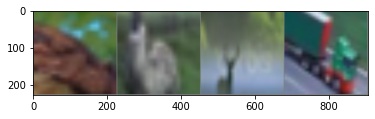

In [9]:
t = torchvision.utils.make_grid(img)
t = t*.5 + .5 #Unnormalization.
plt.imshow(t.numpy().transpose(1, 2, 0))

In [10]:
#Instantiate VGG16
import torchvision.models as models

In [11]:
vgg16 = models.vgg16_bn(pretrained=True) #Load with pretrained weight

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [12]:
#Check the Structure.
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#customize the model /Network

In [75]:
import torch.nn as nn
#as per the last layer this network would classifies to 1000 clasess,
# but we want to have the network only for 10 classes.
# hence we need to modify the network to our need.

# There are multiple way we can modify 
# 1. simple one would be change the parameter once you creating the output.
vgg16_10 = models.vgg16(pretrained=True) #, num_classes=10) 

# Idea number 2: 
# Get the classifier list and modify only the last part.
input_feature = vgg16.classifier[6].in_features
modified_classifier = list(vgg16.classifier.children())[:-1]
#add the last layer.
modified_classifier.extend([nn.Linear(input_feature, 10)])

#change the classifier layer
#vgg16_10.classifier = nn.Sequential(*modified_classifier)

# Idea Number 3:
final_input_feature = vgg16_10.classifier[6].in_features
vgg16_10.classifier[6] = nn.Linear(final_input_feature, 10)
 

In [76]:
#Get the GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [77]:
print(device)

cuda:0


In [78]:
#Since we working on pretrained model we don't want any parameters to be trace for gradient
for param in vgg16_10.parameters():
  param.requires_grad = False

#Alter one more time the last classification layer so that it can be retrained.
#Unfrooze the parameter. ie. Create training parameters.
final_input_feature = vgg16_10.classifier[6].in_features
vgg16_10.classifier[6] = nn.Linear(final_input_feature, 10)


In [79]:
for param in vgg16_10.parameters():
  #if param.requires_grad :
  print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([10, 4096])
torch.Size([10])


In [80]:
#import optim
import torch.optim as optim
vgg16_10 = vgg16_10.to(device)                                       #Move the network to CUDA ie GPU.
loss_fn = nn.CrossEntropyLoss()                                      #As usual choose Cross entropy loss for classfication.
optim = torch.optim.SGD(vgg16_10.parameters(), lr=0.04)              #Optimizer Stocastic Gradient Descent.  

In [81]:
#Modify batch size get loadder again.
bSize = 16
trainData = torch.utils.data.DataLoader(trainset, batch_size=bSize, shuffle=True)
testData = torch.utils.data.DataLoader(trainset, batch_size=bSize, shuffle=False)


In [82]:
a, b = iter(trainData).next()

type(a)
print(a.shape)

torch.Size([16, 3, 224, 224])


In [84]:
#Train it.
loss_on_each_epoch = []
 
epoch  = 1 # 10 is too slow

total_iteration = np.ceil(50000 / bSize)

for i in range(epoch):
  for j, data in enumerate(trainData, 0):
    iData, labels = data   #List of data.

    #Move the input and labels to GPU
    iData = iData.to(device)
    labels = labels.to(device)

    #set optimization grad to ZERO
    optim.zero_grad()

    #Apply Model
    ret = vgg16_10(iData)

    #Find loss (diff)
    loss = loss_fn(ret, labels)

    #Backprobagation.
    loss.backward()

    #Update Gradients / Weights
    optim.step()

    #Get LossValue
    #val = loss.item()

    #Print every 100 Values once 
    if (j % 100  == 0) :
      print("Iteration  %d/%d loss Value =[%0.2f]" %( j, total_iteration, loss.item()))

    # To optimize the memory in GPU delete the processed values.
    del iData, labels, ret
    torch.cuda.empty_cache()

#loss value after complete epoch
loss_on_each_epoch.append(loss.item())

#TODO evalute network performance ie, accuracy.  




Iteration  0/3125 loss Value =[2.22]
Iteration  100/3125 loss Value =[2.57]
Iteration  200/3125 loss Value =[3.22]
Iteration  300/3125 loss Value =[2.29]
Iteration  400/3125 loss Value =[2.60]
Iteration  500/3125 loss Value =[2.87]
Iteration  600/3125 loss Value =[2.02]
Iteration  700/3125 loss Value =[3.01]
Iteration  800/3125 loss Value =[4.26]
Iteration  900/3125 loss Value =[4.20]
Iteration  1000/3125 loss Value =[1.61]
Iteration  1100/3125 loss Value =[1.76]
Iteration  1200/3125 loss Value =[3.31]
Iteration  1300/3125 loss Value =[2.59]
Iteration  1400/3125 loss Value =[3.68]
Iteration  1500/3125 loss Value =[1.66]
Iteration  1600/3125 loss Value =[3.56]
Iteration  1700/3125 loss Value =[3.50]
Iteration  1800/3125 loss Value =[2.30]
Iteration  1900/3125 loss Value =[6.03]
Iteration  2000/3125 loss Value =[2.53]
Iteration  2100/3125 loss Value =[2.96]
Iteration  2200/3125 loss Value =[1.83]
Iteration  2300/3125 loss Value =[2.30]
Iteration  2400/3125 loss Value =[4.75]
Iteration  2

#Check Point :   
---
   Model providing different losses for each batch as seen above.
   Note :
   1. Save the least loss produced weight and apply and use it. 
   2. How to use it.
      1. import copy
      2. Take deep copy of very lower loss produced network configuration.
           Deep Copy:
            *checkpoint_model = copy.deep_copy(vgg16_10.state_dict())*

           Apply it:
            *vgg16_10.load_state_dict(checkpoint_model)*
            check accurecy on both testdata and training data. 


In [ ]:
 ##GOOD LUCK.

 #TODO : Evolution of the network accuracy.

 

#Next Networks
ResNet,
Inception
